Titanic数据集包含11个特征，分别是：

Survived：0代表死亡，1代表存活

Pclass：船舱类别，3类别最高

Name、Sex、Age分别为姓名、性别、年龄，其中年龄有缺失

SibSp:乘客的兄弟姐妹/配偶的个数(整数值)

Parch:乘客的父母/孩子的个数(整数值)

Ticket:船票号码

Fare:船票价格

Cabin:乘客所在船舱（数据大量缺失）

Embark:乘客登船港口:S、C、Q(有缺失)

原文链接：https://blog.csdn.net/weixin_44615820/article/details/88621562

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import pydotplus
from sklearn import metrics
from sklearn.tree import export_graphviz

titanic_=pd.read_csv('../data/titanic.csv')
#舍去无关变量
titanic=titanic_.drop(['PassengerId','Cabin','Name','Ticket','SibSp','Parch','Fare'],axis=1)
titanic.head(10)

,Survived,Pclass,Sex,Age,Embarked
0,0,3,male,22.0,S
1,1,1,female,38.0,C
2,1,3,female,26.0,S
3,1,1,female,35.0,S
4,0,3,male,35.0,S
5,0,3,male,NaN,Q
6,0,1,male,54.0,S
7,0,3,male,2.0,S
8,1,3,female,27.0,S
9,1,2,female,14.0,C


In [4]:
titanic["Age"]=titanic["Age"].fillna(titanic["Age"].mean())
titanic["Embarked"]=titanic["Embarked"].fillna("S")

Pclass是数值型变量，我们将其转化为类别型，然后进行哑变量的处理。比如说Pclass的是三个等级可以表示为001、010、100，这样在决策树上只要判断是否大于或小于0.5就可以区分了，Embarked和Sex也是同理。

In [ ]:
#Pclass,Sex为数值型变量，将其转化为类别型，进行哑变量处理
titanic.Pclass=titanic.Pclass.astype('category')
#哑变量处理
dummy=pd.get_dummies(titanic[['Sex','Pclass','Embarked']])
#水平合并原数据集和哑变量
titanic=pd.concat([titanic,dummy],axis=1)
#删除为处理时时变量，保留哑变量
titanic.drop(['Sex','Pclass','Embarked'],inplace=True,axis=1)
titanic.head(10)

为了防止过拟合，这里采用预剪枝的方法，限制决策树的最大深度、最小的非叶子结点的变量值与最小叶子结点变量值。采用网格搜索法，来对参数进行调优。
GridSearchCV方法，只要把参数输进去，就能给出最优化的结果和参数。比如SVM的惩罚因子C，核函数kernel，gamma参数等

In [6]:
#数据分割
predictors=titanic.columns[1:]
X_train,X_test,y_train,y_test=train_test_split(titanic[predictors],titanic['Survived'],test_size=0.2)
print(predictors)

Index(['Age', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [7]:
#预剪枝，采用网格搜索法调参
max_depth=[4,5,6,7,8]
min_samples_split=[2,4,6,8,10]
min_samples_leaf=[2,4,6,8,10]
parameters={'max_depth':max_depth,'min_samples_split':min_samples_split,'min_samples_leaf':min_samples_leaf}

grid_search=GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=parameters,cv=10,n_jobs=-1)
grid_search.fit(X_train,y_train)
grid_search.best_params_

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 6}

In [10]:
#根据调参结果构建决策树
dtc=DecisionTreeClassifier(max_depth=8,min_samples_split=4,min_samples_leaf=6)
dtc.fit(X_train,y_train)
y_predict=dtc.predict(X_test)
print("决策树模型在测试集上的准确率为：",metrics.accuracy_score(y_test,y_predict))

决策树模型在测试集上的准确率为： 0.7932960893854749


In [9]:
dot_data = export_graphviz(dtc,out_file=None,feature_names=predictors,class_names="Survived",filled=True, rounded=True,special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
  ###保存图像到pdf文件
graph.write_pdf("../out/titanic_tree.pdf")

True

In [13]:
#构建随机森林模型
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(n_estimators=233,random_state=1234)
RF.fit(X_train,y_train)
RF_predict=RF.predict(X_test)
print("随机森林模型在训练集上的准确率为：",metrics.accuracy_score(y_train,RF.predict(X_train)))
print("随机森林模型在测试集上的准确率为：",metrics.accuracy_score(y_test,RF_predict))

随机森林模型在训练集上的准确率为： 0.9101123595505618
随机森林模型在测试集上的准确率为： 0.8044692737430168


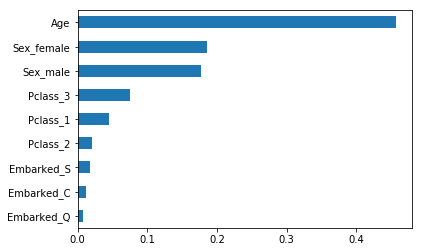

In [12]:
#影响乘客是否幸存的重要因素
importance=RF.feature_importances_
series=pd.Series(importance,index=X_train.columns)
series.sort_values(ascending=True).plot('barh')
plt.show()